## Analysis by stratum 

The objective of this notebook is to graphically represent the impact of COVID in transit user by stratum. 

The analysis only account frequent users [Refer to frequent_users methods se the separation]

In [1]:
import pyspark as ps
from pyspark.sql import * #This enables the SparkSession object
sc = ps.SparkContext(appName="analysis_stratum")

spark = SparkSession.builder\
        .master("local") \
        .appName("analysis_stratum") \
        .getOrCreate()

In [90]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd
import vaex as vaex
import geopandas as gpd
import sys 
import time
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style(style='white')

import time 
import random 
from datetime import date

import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import statsmodels.api as sm
from pyspark.sql.functions import *
from pyspark.sql.functions import sum as _sum

import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.legend_handler import HandlerLine2D

from utils import date_format, save_table, drop_dates

## Functions

In [7]:
def transaction_types(transactions, hw_location):
    """ 
    Returns transactions by origin (home, work, other) made by users. Aggregated by home station
    Input:
    - transactions: Spark dataframe. Row transactions 
    - hw_location : Home and work locations for each frequent user
    """
    
    df = transactions.join(hw_location,on = 'card_id', how = 'inner')

    home_origin = (df['station_name'] == df['home_station']).cast('integer')
    work_origin = (df['station_name'] == df['work_station']).cast('integer')
    other_origin = ((home_origin + work_origin) == 0).cast('integer')

    df = df.withColumn('home_origin', home_origin)\
           .withColumn('work_origin', work_origin)\
           .withColumn('other_origin', other_origin)

    res = df.groupBy(['date', 'home_station'])\
            .agg(sum('home_origin').alias('home_transactions'),
                 sum('work_origin').alias('work_transactions'),
                 sum('other_origin').alias('other_transactions'))
    
    res = res.withColumn('total', col('home_transactions') + col('work_transactions') + col('other_transactions'))
                

    return res

In [8]:
def format_date(df, format_date = '%Y-%m-%d'):
    """ date colum formated as datetime object"""
    df['date'] = pd.to_datetime(df.date, format=format_date)
    return df

def add_day_week(df):
    """ Adds the day of the week.
        0 = Monday, to 6 = Sunday. 
        This value is useful to match baseline values for an entire week. 
        In this way, mondays will be compared to a particular monday, and so on. 
    """
    df['day_week'] = df['date'].dt.weekday
    return df

In [9]:
def merge_probs(df, probabilities):
    result = df.merge(probabilities, how = 'left', 
                      left_on = ['date', 'home_station'], 
                      right_on = ['date', 'station_name']).dropna()
    return result#.rename(columns = {'nombreestacion':'home'})

In [10]:
def by_stratum_station(df):
    """
    Calculates daily transactions by stratum at the station level 
    Input 
    - df: DataFrame. Output of merge_probs function
    """
    df = df.rename(columns = {'home_transactions':'home',
                         'work_transactions':'work',
                         'other_transactions':'other'})
    
#     strata = ['stratum1', 'stratum2', 'stratum3',
#               'stratum4','stratum5', 'stratum6']
    strata = ['stratum1', 'stratum2', 'stratum3',
              'stratum4','stratum56']
    
    origin = ['home', 'work', 'other', 'total']
    
    name_list = []
    data_list = []
    for x in origin:
        for y in strata:
            name = x + '_' + y
            transactions = df[x] * df [y]
            name_list.append(name)
            data_list.append(transactions)
            
    transactions_by_stratum = pd.concat(data_list, axis = 1)

    
    df[name_list] = transactions_by_stratum
    
    return df


In [11]:
def by_stratum_daily(df):
    """ Calculate daily transactions by stratum. 
        Input
        - df: DataFrame. Output of by_stratum_station function
        """
    
#     strata = ['stratum1', 'stratum2', 'stratum3',
#               'stratum4','stratum5', 'stratum6']
    strata = ['stratum1', 'stratum2', 'stratum3',
              'stratum4','stratum56']
    
    
    origin = ['home', 'work', 'other', 'total']
    
    agg_dict = {}
    for x in origin:
        for y in strata:
            name = x + '_' + y
            agg_dict[name] = 'sum'

    agg_dict['day_week'] = 'first'
    results = df.groupby('date').agg(agg_dict).reset_index()
    return results

In [12]:
def add_baseline(df):
    ''' Add number of transactions of baseline day'''
    
    baseline_dates = list(pd.date_range(start = '2/17/2020', end = '2/23/2020'))
    baseline = df[df.date.isin(baseline_dates)].drop(columns = 'date')
    result = df.merge(baseline, how = 'left', on = 'day_week', 
                      suffixes = ('_t', '_baseline'))
    return result 

In [13]:
def add_pct(df, rolling_window = 1):
    """ Adds percentages columns """
#     baseline_names = df.columns[df.columns.str.endswith('_baseline')]
#     transactions_names = df.columns[df.columns.str.endswith('_t_t')]
    col_names = df.columns[df.columns.str.contains('_t')].str[:-2]
    col_names

    for name in col_names:
        transactions = name + '_t'
        baseline = name + '_baseline'
        new_col_name = name + '_pct' 
        df[new_col_name] = df[transactions].div(df[baseline], axis = 0)
    return df.set_index('date').rolling(window=rolling_window).mean().reset_index().dropna().reset_index()

In [86]:
def melt_strata(df, melt_type = '_pct'): 
    cols_names = df.columns[df.columns.str.contains(melt_type)]
    return df.melt(id_vars = ['date'], value_vars = cols_names)

In [87]:
def stratum_population(df):
    populations_dict = {1: 735748, 2: 3327722, 3: 2857861, 4: 757923, 5: 240570, 6: 124889}
    populations_dict = {1: 735748, 2: 3327722, 3: 2857861, 4: 757923, 5: 365459}
    df['stratum'] = df.variable.str.extract('(\d+)').astype(int)
    df['population'] = df.stratum.replace(populations_dict)
    df['pop/trans'] = df.population/df['value']
    df['trans_per_1000'] = 1000 * df['value'] / df.population
    return df

def regression_vars(df):
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekend'] = (df['dayofweek'].between(5,6)).astype(int)
    df['stratum'] = df.variable.str.extract('(\d+)').astype(int)
    df['origin'] = df.variable.str.extract('(^[^_]+(?=_))')
    
    df = df[df.origin != 'total']
    df = df[df.weekend == 0]
    return df 

In [88]:
linewidth=7
def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(7)

## Input files 

In [15]:


transactions = spark.read.csv(output_path + 'tables/transactions_frequent_users.csv', header =True, sep = ',')
hw_location = spark.read.csv(output_path + 'tables/hw_location.csv', header =True, sep = ',')
probs = pd.read_csv(output_path + 'tables/stratum_probabilities.csv', parse_dates = ['date'],
                    infer_datetime_format= True).drop(columns = 'total')

In [16]:
%%time 
# Transaction by day by station and by origin type
transactions_stations = transactions.withColumn('date', date_format())\
                                    .transform(lambda df: transaction_types(df, hw_location))\
                                    .toPandas()

save_table(transactions_stations, 'transactions_by_origin.csv')

CPU times: user 874 ms, sys: 108 ms, total: 982 ms
Wall time: 3min 38s


## Finding 1. Low strata reduced transit use in least amount 

In [18]:
output_path = '../data/output/'
input_path = '../data/input/'

probs = pd.read_csv(output_path + 'tables/stratum_probabilities_V2.csv', parse_dates = ['date'],
                    infer_datetime_format= True).drop(columns = 'total')

transactions_stations = pd.read_csv(output_path + 'tables/transactions_by_origin.csv', index_col = 0)

In [56]:
df = transactions_stations.pipe(format_date)\
                     .pipe(add_day_week)\
                     .pipe(merge_probs, probs.pipe(format_date))\
                     .pipe(by_stratum_station)\
                     .pipe(by_stratum_daily)\
                     .pipe(add_baseline)\
                     .pipe(add_pct, rolling_window = 7)\
                     .pipe(drop_dates)\
                     .pipe(melt_strata)

### Plot

In [57]:
# Reduction of transactions by stratum
total_t = df[df.variable.str.contains('total')]
total_t['stratum'] = total_t.variable.str.extract('(\d+)')
total_t['value(%)'] = (1 - total_t['value']) * 100
total_t.stratum.replace('56','5 & 6', inplace = True)

In [58]:
palette = [[0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
           [0.8559578605899612, 0.6418993116910497, 0.6754191211563135],
           [0.739734329496642, 0.4765280683170713, 0.5959617419736206],
           [0.57916573903086, 0.33934576125314425, 0.5219003947563425],
           [0.37894937987025, 0.2224702044652721, 0.41140014301575434]]
color = 'firebrick'

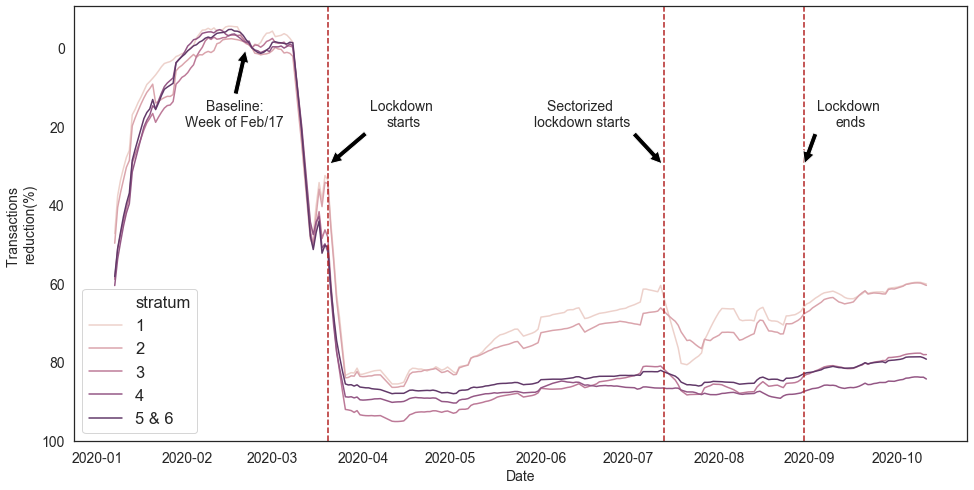

In [59]:
#Plot
# Main plot 
fig, axs = plt.subplots(figsize = (16,8))
sns.lineplot(x='date', y = 'value(%)',hue='stratum', 
             data = total_t, 
             ci = None, ax = axs,legend='full', palette=palette)
axs.set_ylabel('Transactions \nreduction(%)', fontsize = 14, horizontalalignment='center')
axs.set_xlabel('Date', fontsize = 14)
axs.set_ylim(axs.get_ylim()[::-1])

#Baseline
dates = pd.date_range(start = '2/21/2020', end = '2/21/2020')
text = pd.date_range(start = '2/17/2020', end = '2/17/2020')
axs.annotate('Baseline:\nWeek of Feb/17', xy = (dates,0),xytext=(text,20),
             arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':5},
            horizontalalignment='center',fontsize = 14)

# axs.text(x = date, y = 0.8, s = 'Baseline:\nWeek of Feb/17', fontsize = 14)

#Lockdown starts 
dates = pd.date_range(start = '3/20/2020', end = '3/20/2020')
text = pd.date_range(start = '4/15/2020', end = '4/15/2020')
axs.axvline(dates, color=color,ls='--')
axs.annotate('Lockdown \nstarts', xy = (dates,30),xytext=(text,20),
             arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':5},
            horizontalalignment='center',fontsize = 14)

#Sectorized lockdown starts 
dates = pd.date_range(start = '7/13/2020', end = '7/13/2020')
text = pd.date_range(start = '6/15/2020', end = '6/15/2020')
axs.axvline(dates, color=color,ls='--')
axs.annotate('Sectorized \nlockdown starts', xy = (dates,30),xytext=(text,20),
             arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':5},
            horizontalalignment='center',fontsize = 14)

#Lockdown ends 
dates = pd.date_range(start = '8/30/2020', end = '8/30/2020')
text = pd.date_range(start = '9/15/2020', end = '9/15/2020')
axs.axvline(dates, color=color,ls='--')
axs.annotate('Lockdown \nends', xy = (dates,30),xytext=(text,20),
             arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':5},
            horizontalalignment='center',fontsize = 14)

axs.legend(loc = 'lower left');

fig.savefig(output_path + 'figures/figure4.pdf')

### Statistical analysis - Hypothesis testing 

In [60]:
transactions = transactions_stations
rolling_window = 1
date_start = date(2020,3,23)
date_end =date(2020,7,12)

In [65]:
def ht_short(transactions = transactions_stations,
             rolling_window = 1, 
             date_start = date(2020,3,23),
             date_end =date(2020,7,12)):
    ''' Runs hypothesis testing for finding 1. 1 OLS by strata'''

    df = transactions.pipe(format_date)\
                         .pipe(add_day_week)\
                         .pipe(merge_probs, probs.pipe(format_date))\
                         .pipe(by_stratum_station)\
                         .pipe(by_stratum_daily)\
                         .pipe(add_baseline)\
                         .pipe(add_pct, rolling_window = rolling_window)\
                         .pipe(drop_dates)\
                         .pipe(melt_strata)
    
    date_zero = int(date_start.strftime('%j'))
    date_start, date_end = str(date_start), str(date_end)

    #Transformations 
    df_ht = df
    df_ht['slope'] = df_ht['date'].dt.dayofyear - date_zero +1 
    df_ht['dayofweek'] = df_ht['date'].dt.dayofweek
    df_ht['weekend'] = (df_ht['dayofweek'].between(5,6)).astype(int)
    df_ht['stratum'] = df_ht.variable.str.extract('(\d+)').astype(int)
    df_ht['origin'] = df_ht.variable.str.extract('(^[^_]+(?=_))')
    
    #Filter dates 
    part_one = df_ht[df_ht['date'].between(date_start, date_end)]

    #Select total transactions
    part_one['constant'] = 1
    part_one = part_one[part_one.origin == 'total']

    x_vars = ['constant', 'slope', 'weekend']
    strata = [1,2,3,4,56]

    models_ = []
    for stratum in strata: 
        x = part_one[part_one['stratum'] == stratum]
        y = part_one[part_one['stratum'] == stratum].value * 100

        models_.append(sm.OLS(y, x[x_vars]).fit())
        
    summary_table = summary_col(models_,stars=True, 
                           info_dict = {"N":lambda x:(x.nobs)},
                           model_names = ['Stratum 1', 'Stratum 2', 'Stratum 3', 'Stratum 4', 'Strata 5 & 6'], 
                          regressor_order = x_vars,
                          float_format='%.3f')
    return summary_table

In [68]:
table_1 = ht_short(transactions = transactions_stations,
             rolling_window = 1, 
             date_start = date(2020,3,23),
             date_end =date(2020,7,12))

print(table_1.as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lccccc}
\hline
          & Stratum 1 & Stratum 2 & Stratum 3 & Stratum 4 & Strata 5 \& 6  \\
\midrule
constant  & 12.110*** & 12.118*** & 3.054***  & 6.691***  & 7.568***       \\
          & (0.654)   & (0.479)   & (0.419)   & (0.454)   & (0.674)        \\
slope     & 0.248***  & 0.195***  & 0.135***  & 0.044***  & 0.054***       \\
          & (0.010)   & (0.007)   & (0.006)   & (0.007)   & (0.010)        \\
weekend   & 3.607***  & 4.933***  & 3.845***  & 11.296*** & 14.939***      \\
          & (0.688)   & (0.503)   & (0.440)   & (0.477)   & (0.709)        \\
R-squared & 0.877     & 0.900     & 0.852     & 0.862     & 0.831          \\
          & 0.879     & 0.902     & 0.855     & 0.865     & 0.834          \\
N         & 99.0000   & 99.0000   & 99.0000   & 99.0000   & 99.0000        \\
\hline
\end{tabular}
\end{center}
\end{table}


In [69]:
table_2 = ht_short(transactions = transactions_stations,
             rolling_window = 1, 
             date_start = date(2020,9,1), 
                   date_end =date(2020,10,12))

print(table_2.as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lccccc}
\hline
          & Stratum 1 & Stratum 2 & Stratum 3 & Stratum 4 & Strata 5 \& 6  \\
\midrule
constant  & 34.091*** & 32.154*** & 14.545*** & 8.740***  & 12.994***      \\
          & (0.998)   & (0.792)   & (0.708)   & (0.935)   & (0.880)        \\
slope     & 0.095**   & 0.137***  & 0.118***  & 0.073*    & 0.089**        \\
          & (0.041)   & (0.032)   & (0.029)   & (0.038)   & (0.036)        \\
weekend   & 7.783***  & 9.243***  & 11.247*** & 15.625*** & 17.134***      \\
          & (1.058)   & (0.839)   & (0.750)   & (0.991)   & (0.933)        \\
R-squared & 0.608     & 0.789     & 0.865     & 0.867     & 0.899          \\
          & 0.628     & 0.799     & 0.872     & 0.873     & 0.904          \\
N         & 41.0000   & 41.0000   & 41.0000   & 41.0000   & 41.0000        \\
\hline
\end{tabular}
\end{center}
\end{table}


In [23]:
def hypothesis_testing_1(transactions, 
                         rolling_window = 7, 
                         date_start = date(2020,3,23), 
                         date_end =date(2020,7,12), 
                         espc = 'model_4'):
    
    "Hypotheis testing for finding 1"
    
    df1 = transactions.pipe(format_date)\
                     .pipe(add_day_week)\
                     .pipe(merge_probs, probs.pipe(format_date))\
                     .pipe(by_stratum_station)\
                     .pipe(by_stratum_daily)\
                     .pipe(add_baseline)\
                     .pipe(add_pct, rolling_window = rolling_window)\
                     .pipe(drop_dates)\
                     .pipe(melt_strata)
    
    date_zero = int(date_start.strftime('%j'))
    date_start, date_end = str(date_start), str(date_end)
    
    #Transformations 
    df_ht = df1
    df_ht['day'] = df_ht['date'].dt.dayofyear - date_zero +1 
    df_ht['dayofweek'] = df_ht['date'].dt.dayofweek
    df_ht['weekend'] = (df_ht['dayofweek'].between(5,6)).astype(int)
    df_ht['stratum'] = df_ht.variable.str.extract('(\d+)').astype(int)
    df_ht['origin'] = df_ht.variable.str.extract('(^[^_]+(?=_))')
    
    #Filter dates 
    part_one = df_ht[df_ht['date'].between(date_start, date_end)]

    part_one['constant'] = 1
    part_one = part_one[part_one.origin == 'total']
#     print( part_one.date.nunique())
    # Add stratum categorical data and interactions 
    stratum_vars = []
    stratum_day_vars = []
    stratum_weekend_vars = []
    for i in range(1,5):
        #Var names 
        stratum = 'stratum '+ str(i)
        stratum_day = 'stratum' + str(i) + '* day'
        stratum_weekend = 'stratum' + str(i) + '* weekend'
        
        #Var values 
        part_one[stratum] = (part_one.stratum == i).astype(int)
        part_one[stratum_day] = part_one[stratum] * part_one['day']
        part_one[stratum_weekend] = part_one[stratum] * part_one['weekend']
        
        #Saving var names 
        stratum_vars.append(stratum)
        stratum_day_vars.append(stratum_day)
        stratum_weekend_vars.append(stratum_weekend)
    
    # organize data for linear regression estimation     
    x = part_one
    y = part_one.value * 100 #Multiply by 100 to get percentages.
    
    model_1 = ['constant','day']
    model_2 = model_1 + ['weekend']
    model_3 = model_2 + stratum_vars
    model_4 = model_3 + stratum_weekend_vars
    model_5 = model_3 + stratum_day_vars + stratum_weekend_vars
    
    if espc == 'model_4':
        model = sm.OLS(y, x[model_4]).fit()
    elif espc == 'model_5':
        model = sm.OLS(y, x[model_5]).fit() 
    return model, model_5

In [84]:
before_sectorize, espc = hypothesis_testing_1(transactions_stations, 
                         rolling_window = 1, 
                         date_start = date(2020,3,23), 
                         date_end =date(2020,7,12), 
                                       espc = 'model_5')


after_restrictions, espc = hypothesis_testing_1(transactions_stations, 
                         rolling_window = 1, 
                         date_start = date(2020,9,1), 
                         date_end =date(2020,10,12), 
                                         espc= 'model_4')


In [85]:
fitted_modes = [before_sectorize, after_restrictions]
summary_table = summary_col(fitted_modes,stars=True, 
                           info_dict = {"N":lambda x:(x.nobs)},
                           model_names = ['Model 1', 'Model 2'], 
                          regressor_order = espc,
                          float_format='%.2f')
print(summary_table.as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lcc}
\hline
                  &  Model 1  & Model 2   \\
\midrule
constant          & 7.57***   & 12.73***  \\
                  & (0.55)    & (0.59)    \\
day               & 0.05***   & 0.10***   \\
                  & (0.01)    & (0.02)    \\
weekend           & 14.94***  & 17.10***  \\
                  & (0.57)    & (0.91)    \\
stratum 1         & 4.54***   & 21.21***  \\
                  & (0.77)    & (0.70)    \\
stratum 2         & 4.55***   & 20.11***  \\
                  & (0.77)    & (0.70)    \\
stratum 3         & -4.51***  & 2.14***   \\
                  & (0.77)    & (0.70)    \\
stratum 4         & -0.88     & -4.59***  \\
                  & (0.77)    & (0.70)    \\
stratum1* day     & 0.19***   &           \\
                  & (0.01)    &           \\
stratum2* day     & 0.14***   &           \\
                  & (0.01)    &           \\
stratum3* day     & 0.08***   &           \\
                  & (0.

## Finding 2. The growth of “Other” origin trips rate is higher than home and work origin trips for low and middle strata after the end of the restrictions. 

In [99]:
def stratum_population(df):
#     populations_dict = {1: 735748, 2: 3327722, 3: 2857861, 4: 757923, 5: 240570, 6: 124889}
    populations_dict = {1: 735748, 2: 3327722, 3: 2857861, 4: 757923, 56: 365459,}
    df['stratum'] = df.variable.str.extract('(\d+)').astype(int)
    df['population'] = df.stratum.replace(populations_dict)
    df['pop/trans'] = df.population/df['value']
    df['trans_per_1000'] = 1000 * df['value'] / df.population
    return df

def regression_vars(df):
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekend'] = (df['dayofweek'].between(5,6)).astype(int)
    df['stratum'] = df.variable.str.extract('(\d+)').astype(int)
    df['origin'] = df.variable.str.extract('(^[^_]+(?=_))')
    
    df = df[df.origin != 'total']
#     df = df[df.weekend == 0]
    return df 

In [126]:
df = transactions_stations.pipe(format_date)\
                     .pipe(add_day_week)\
                     .pipe(merge_probs, probs.pipe(format_date))\
                     .pipe(by_stratum_station)\
                     .pipe(by_stratum_daily)\
                     .pipe(add_baseline)\
                     .pipe(add_pct, 7)\
                     .pipe(drop_dates)\
                     .pipe(melt_strata, '_t')\
                     .pipe(stratum_population)\
                     .pipe(regression_vars)

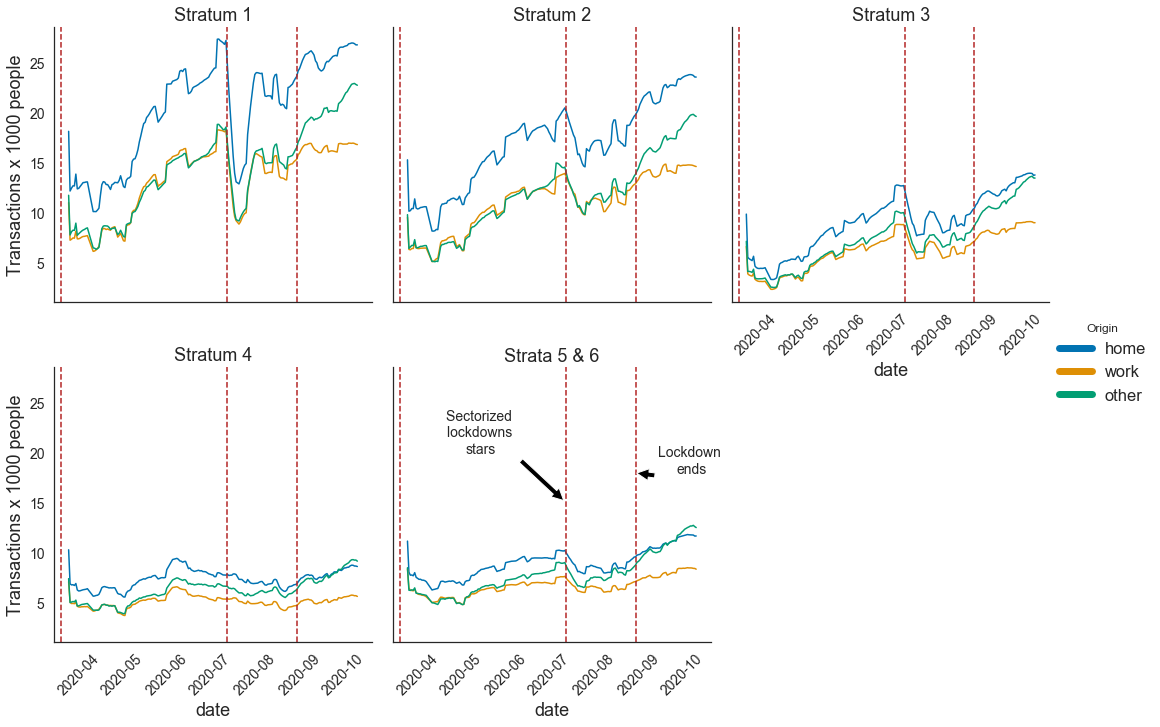

In [127]:
to_graph = 'trans_per_1000'
mask = df.date > '2020-03-24' #Only recovery period 
to_plot = df[mask]

g = sns.FacetGrid(to_plot, hue="origin", col="stratum" ,sharey= True,  
                  height=5, col_wrap = 3, palette='colorblind')
g = g.map(sns.lineplot, "date",to_graph)

g.set_xticklabels(rotation = 45, fontsize = 14)
g.set_xlabels('date', fontsize = 18)
g.set_ylabels('Transactions x 1000 people', fontsize = 18)
dates = pd.date_range(start = '3/20/2020', end = '3/20/2020')

#Sectorize quarentine 
date_2a = pd.date_range(start = '7/13/2020', end = '7/13/2020')
date_5b = pd.date_range(start = '8/30/2020', end = '8/30/2020')

text = pd.date_range(start = '5/15/2020', end = '5/15/2020')
g.axes.flat[4].annotate('Sectorized \nlockdowns \nstars', xy = (date_2a,15),xytext=(text,20),
             arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':5},
            horizontalalignment='center',fontsize = 14)

text = pd.date_range(start = '10/8/2020', end = '10/8/2020')
g.axes.flat[4].annotate('Lockdown \nends', xy = (date_5b,18),xytext=(text,18),
             arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':5},
            horizontalalignment='center',fontsize = 14)

i = 1 
for ax in g.axes.flat:
    ax.axvline(dates, color='firebrick',ls='--', label = 'Restrictions starts')
    ax.axvline(date_2a, color='firebrick',ls='--',label = 'Localizided restrictions')
    ax.axvline(date_5b, color='firebrick',ls='--')
    
    if i <= 4:
        ax.set_title('Stratum '+ str(i))
    else:
        ax.set_title('Strata 5 & 6')
    i = i + 1


handles = [g.axes.flat[0].get_legend_handles_labels()[0][x] for x in range(3)]

g.add_legend(title = 'Origin', handlelength=2, handler_map={plt.Line2D : HandlerLine2D(update_func=update)});

g.savefig(output_path + 'figures/figure5.pdf')

### Statistical analysis 

In [121]:
def hypothesis_testing_2(df, 
                         date_start = date(2020,9,1), 
                         date_end = date(2020,10,12)):
    
    "Hypotheis testing for finding 2"

    
    date_zero = int(date_start.strftime('%j'))
    date_start, date_end = str(date_start), str(date_end)
    
    #Transformations 
    df_ht = df
    df_ht['slope'] = df_ht['date'].dt.dayofyear - date_zero + 1 


    #Filter dates 
    part_one = df_ht[df_ht['date'].between(date_start, date_end)]

    
    part_one['constant'] = 1
    
    # Add stratum categorical data and interactions 
    stratum_vars = []
    stratum_day_vars = []
    
    for i in range(1,6):
        #Var names 
        stratum = 'stratum '+ str(i)
        stratum_day = 'stratum' + str(i) + '* day'
        
        #Var values 
        part_one[stratum] = (part_one.stratum == i).astype(int)
        part_one[stratum_day] = part_one[stratum] * part_one['day']
        
        #Saving var names 
        stratum_vars.append(stratum)
        stratum_day_vars.append(stratum_day)
        
    origins = ['home', 'work', 'other']
    day_origin_vars = []
    for origin in origins:
        day_origin_name = 'slope - ' + origin
        part_one[origin] = (part_one['origin'] == origin).astype(int)
        part_one[day_origin_name] = part_one['slope'] * part_one[origin]
        day_origin_vars.append(day_origin_name)
        
    #Linear regression 
    fitted_modes = []
    for i in range(1,6): #6 strata
        data = part_one[part_one.stratum == i]
        y = data['trans_per_1000']
#         x = data[['constant','work', 'other','slope','slope * work', 'slope * other']]
        x = data[['home','work', 'other','slope - home','slope - work', 'slope - other']]
        fitted_modes.append(sm.OLS(y, x).fit())

    dfoutput = summary_col(fitted_modes,stars=True, 
                       info_dict = {"N":lambda x:(x.nobs)}, 
                       model_names = ['Stratum 1:\nTrans x \n1000 people',
                                      'Stratum 2:\nTrans x \n1000 people',
                                      'Stratum 3:\nTrans x \n1000 people',
                                      'Stratum 4:\nTrans x \n1000 people',
                                      'Strata 5 & 6:\nTrans x \n1000 people',],
#                                       'Stratum 6:\nTrans x \n1000 people'],
                           float_format='%.3f') 
    return dfoutput, part_one

In [122]:
df.stratum.replace(56,5, inplace = True)
table_3, df = hypothesis_testing_2(df,date_start = date(2020,9,1), 
                         date_end =date(2020,10,12))

print(table_3.as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lccccc}
\hline
              &  Stratum 1: &  Stratum 2: &  Stratum 3: &  Stratum 4: & Strata 5 \& 6:  \\
              &   Trans x   &   Trans x   &   Trans x   &   Trans x   &    Trans x      \\
              & 1000 people & 1000 people & 1000 people & 1000 people &  1000 people    \\
\midrule
home          & 24.747***   & 20.752***   & 11.151***   & 7.264***    & 9.874***        \\
              & (0.155)     & (0.120)     & (0.088)     & (0.072)     & (0.057)         \\
work          & 16.317***   & 13.683***   & 7.632***    & 4.985***    & 7.270***        \\
              & (0.155)     & (0.120)     & (0.088)     & (0.072)     & (0.057)         \\
other         & 17.916***   & 14.888***   & 9.223***    & 6.581***    & 9.160***        \\
              & (0.155)     & (0.120)     & (0.088)     & (0.072)     & (0.057)         \\
slope - home  & 0.049***    & 0.080***    & 0.071***    & 0.034***    & 0.052***        \\
          

In [ ]:
# to_graph = 'trans_per_1000'
# g = sns.FacetGrid(df3, col="origin", hue="stratum" ,sharey= True,  height=5, palette= 'colorblind')
# g = g.map(sns.lineplot, "date",to_graph)

# g.set_xticklabels(rotation = 45, fontsize = 14)
# g.set_xlabels('Data', fontsize = 18)
# g.set_ylabels('Transactions per 1000 people', fontsize = 18)
# g.set_titles(col_template="{col_name} origin")
# # g.set(ylabel = 'Number of Trips', xlabel = 'Date')
# date = pd.date_range(start = '3/20/2020', end = '3/20/2020')

# #Sectorize quarentine 
# date_2a = pd.date_range(start = '7/13/2020', end = '7/13/2020')
# date_5b = pd.date_range(start = '8/30/2020', end = '8/30/2020')


# for ax in g.axes.flat:
#     ax.axvline(date, color='firebrick',ls='--', label = 'Restrictions starts')
#     ax.axvline(date_2a, color='firebrick',ls='--',label = 'Localizided restrictions')
#     ax.axvline(date_5b, color='firebrick',ls='--')
# #     ax.legend(loc = 'upper right')

# g.add_legend();